# 2022 Women in Data Science ("WiDS") Kaggle Competition

- **Purpose**: This notebook contains my final solution for the 2022 WiDS Kaggle Competition.
- **Problem Scope**: Using machine learning to predict building energy usage (regression).
- **Final leaderboard rank**: 81 / 829 (Top 10%) after removing accounts deleted for cheating.
- **Related GitHub repository**: https://github.com/nicovandenhooff/wids-datathon-2022
- **Author**: [Nico Van den Hooff, CPA](https://www.linkedin.com/in/nicovandenhooff/)
- **Occupaction**: Graduate Student in the Master of Data Science program at the University of British Columbia.

# Abstract

> *This Kaggle notebook contains my final solution to the 2022 WiDS competition.  The competition involved predicting a buildings Site Energy Usage Intensity metric, which was the `site_eui` feature in the dataset (regression problem).  To solve this problem, I first separated the dataset into twelve individual datasets based on buildings with similar `site_eui` usage patterns and other characteristics.  I then engineer features, perform leave one group out cross validation, and finally train 12 individual ensemble models (XGBoost, LightGBM, and CatBoost regressors) on the most promising features to get the final predictions for the competition.  My final solution ended up in the top 10% of the final leaderboard.*

# Table of Contents

* [Section 1: Notebook Set Up](#Section-1:-Notebook-Set-Up)
* [Section 2: Helper Functions](#Section-2:-Helper-Functions)
* [Section 3: Data Preprocessing](#Section-3:-Data-Preprocessing)
* [Section 4: Feature Engineering](#Section-4:-Feature-Engineering)
* [Section 5: Modelling](#Section-5:-Modelling)
* [Section 6: Final models and predictions](#Section-6:-Final-models-and-predictions)

# Section 1: Notebook Set Up

In this section I import the packages that are used throughout my solution and I perform general notebook set up.

## 1.1 Imports

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import defaultdict

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, LeaveOneGroupOut

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## 1.2 Global notebook variables

In [2]:
TRAIN_PATH = "../input/widsdatathon2022/train.csv"
TEST_PATH = "../input/widsdatathon2022/test.csv"
SUBMISSION_PATH = "../output/"
TARGET = "site_eui"
SCORE = "neg_root_mean_squared_error"
SEED = 777

# Section 2: Helper Functions

This section contains several helper functions that are used throughout my notebook.  I have hidden the cell on the Kaggle viewer, as there are almost 800 lines of code here.  Please feel free to expand it and read the code.  You can also find all of the function organized into scripts on my [GitHub repository](https://github.com/nicovandenhooff/wids-datathon-2022https://github.com/nicovandenhooff/wids-datathon-2022).

In [3]:
def read_data(train_path, test_path):
    """Read in train and test data for a kaggle competition.

    Parameters
    ----------
    train_path : str
        The path to the training data.
    test_path : str
        The path to the test data

    Returns
    -------
    train_df, test_df : pandas DataFrames
        The train and test datasets.
    """
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df


def get_duplicates(df, drop_cols=None):
    """Determine and return the duplicated values in a dataframe.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to check
    drop_cols : str or list of str, optional
        The columns to drop before returning duplicates.

    Returns
    -------
    pandas DataFrame
        A dataframe containing the rows with duplicated values.
    """
    if drop_cols is not None:
        return df[df.drop(columns=drop_cols).duplicated()]
    else:
        return df[df.duplicated()]
    

def remove_duplicates(df, drop_cols=None):
    """Removes the duplicated values in a dataframe.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to check
    drop_cols : str or list of str, optional
        The columns to drop before removing duplicates.
    Returns
    -------
    pandas DataFrame
        A dataframe without duplicated.
    """
    df_clean = df.copy()

    if drop_cols is not None:
        df_clean = df_clean[~df_clean.drop(columns=drop_cols).duplicated()]
    else:
        df_clean = df_clean[~df_clean.duplicated()]
    
    return df_clean.reset_index(drop=True)


def split_building_data(df, groups):
    """Splits the WiDS 2022 dataset based on groups of facility types.

    Parameters
    ----------
    df : pandas DataFrame
        The WiDS train or test dataset.
    groups : dict (key: str, value: set)
        The dictionary of facility types.  The key should be the desired group name.
        The value should be a set containing the facility types in a given group.

    Returns
    -------
    dfs : dict
        A dictionary of pandas DataFrames, one for each group.
    """
    dfs = {}

    for name, group in groups.items():
        group_df = df.query("facility_type in @group")
        dfs[name] = group_df.reset_index(drop=True)

    return dfs


def get_manual_facility_groups():
    """Returns the manual facility groups used in my final WiDS solution.

    Returns
    -------
    The dictionary of facility types.
        The key is group name (first word in facility type).
        The value is a set containing the facility types in a given group.
    """

    facility_groups = {
        "2to4_5plus_Mixed": {
            "2to4_Unit_Building",
            "5plus_Unit_Building",
            "Mixed_Use_Predominantly_Residential",
        },
        "Commercial_Education_Mixed_Industrial_Parking": {
            "Education_College_or_university",
            "Education_Other_classroom",
            "Education_Preschool_or_daycare",
            "Education_Uncategorized",
            "Commercial_Other",
            "Commercial_Unknown",
            "Mixed_Use_Commercial_and_Residential",
            "Mixed_Use_Predominantly_Commercial",
            "Industrial",
            "Parking_Garage",
        },
        "Food_Grocery": {
            "Food_Sales",
            "Food_Service_Other",
            "Food_Service_Restaurant_or_cafeteria",
            "Food_Service_Uncategorized",
            "Grocery_store_or_food_market",
        },
        "Health": {
            "Health_Care_Inpatient",
            "Health_Care_Outpatient_Clinic",
            "Health_Care_Outpatient_Uncategorized",
            "Health_Care_Uncategorized",
        },
        "Laboratory_Data": {"Laboratory", "Data_Center"},
        "Lodging": {
            "Lodging_Dormitory_or_fraternity_sorority",
            "Lodging_Hotel",
            "Lodging_Other",
            "Lodging_Uncategorized",
        },
        "Multifamily": {"Multifamily_Uncategorized"},
        "Office_Nursing": {
            "Office_Bank_or_other_financial",
            "Office_Medical_non_diagnostic",
            "Office_Mixed_use",
            "Office_Uncategorized",
            "Nursing_Home",
        },
        "Public": {
            "Public_Assembly_Drama_theater",
            "Public_Assembly_Entertainment_culture",
            "Public_Assembly_Library",
            "Public_Assembly_Movie_Theater",
            "Public_Assembly_Other",
            "Public_Assembly_Recreation",
            "Public_Assembly_Social_meeting",
            "Public_Assembly_Stadium",
            "Public_Assembly_Uncategorized",
            "Public_Safety_Courthouse",
            "Public_Safety_Fire_or_police_station",
            "Public_Safety_Penitentiary",
            "Public_Safety_Uncategorized",
        },
        "Religious": {"Religious_worship"},
        "Retail": {
            "Retail_Enclosed_mall",
            "Retail_Strip_shopping_mall",
            "Retail_Uncategorized",
            "Retail_Vehicle_dealership_showroom",
        },
        "Warehouse_Service": {
            "Warehouse_Distribution_or_Shipping_center",
            "Warehouse_Nonrefrigerated",
            "Warehouse_Refrigerated",
            "Warehouse_Selfstorage",
            "Warehouse_Uncategorized",
            "Service_Drycleaning_or_Laundry",
            "Service_Uncategorized",
            "Service_Vehicle_service_repair_shop",
        },
    }

    return facility_groups


def count_missing(df):
    """Counts the missing data in a dataframe.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to count the missing data in.

    Returns
    -------
    pandas DataFrame
        A summary of missing data (counts and %)
    """
    missing_df = pd.DataFrame(
        df.isna().sum().sort_values(ascending=False), columns=["count"]
    )
    missing_df["percent"] = missing_df["count"] / df.shape[0]
    return missing_df.query("count != 0")


def iterative_impute(train_df, test_df, model, ct, target, feat_names, seed):
    """Imputes missing data into train and test datasets with a ML model of choice.

    Parameters
    ----------
    train_df : pandas DataFrame
        The training dataset
    test_df : pandas DataFrame
        The test dataset
    model : sklearn estimator
        The machine learning model to use for imputation
    ct : sklearn ColumnTransformer
        The column transformer to perform on the dataset
    target : str
        The target variable (removed before imputation)
    feat_names : list
        Names of features to append to OHE features from column transformer.
    seed : int
        The random seed for imputation.

    Returns
    -------
    train_imp, test_imp
        Train and test datasets with imputed values.
    """
    train_imp = ct.fit_transform(train_df.drop(columns=[target]))
    test_imp = ct.transform(test_df)

    imputer = IterativeImputer(estimator=model, random_state=seed)

    cols = (
        ct.named_transformers_["onehotencoder"].get_feature_names().tolist()
        + feat_names
    )

    train_imp = pd.DataFrame(imputer.fit_transform(train_imp), columns=cols)
    test_imp = pd.DataFrame(imputer.transform(test_imp), columns=cols)

    return train_imp, test_imp


def replace_columns(df, df_imp, columns):
    """Replace columns in a dataframe with columns from another.

    Note: Meant for use with imputed datasets for WiDS 2022.

    Parameters
    ----------
    df : pandas DataFrame
        The original dataframe.
    df_imp : pandas DataFrame
        The imputed dataframe.
    columns : str or list of str
        The columns to replace between dataframes.

    Returns
    -------
    df_replaced : pandas DataFrame
        Dataframe with replaced columns.
        
    """
    df_replaced = df.copy()

    for col in columns:
        df_replaced[col] = df_imp[col]

    return df_replaced


def impute_and_replace(
    train_dfs, test_dfs, model, ct, target, feat_names, replace, seed
):
    """Iteratively impute multiple dataframes.

    Note: Meant for use solely with WiDS 2022 data.  This simple calls
    the `iterative_impute` and `replace_column` functions for each
    individual dataset in my final WiDS solution.  
    """
    train_dfs_imp = {}
    test_dfs_imp = {}

    # iterative imputation
    for (name1, train_df), (name2, test_df) in zip(train_dfs.items(), test_dfs.items()):
        train_imp, test_imp = iterative_impute(
            train_df, test_df, model, ct, target, feat_names, seed
        )
        train_dfs_imp[name1] = train_imp
        test_dfs_imp[name1] = test_imp

    # replace train columns with missing values
    for (name1, df), (name2, imp_df) in zip(train_dfs.items(), train_dfs_imp.items()):
        train_dfs[name1] = replace_columns(df, imp_df, replace)

    # replace test columns with missing values
    for (name1, df), (name2, imp_df) in zip(test_dfs.items(), test_dfs_imp.items()):
        test_dfs[name1] = replace_columns(df, imp_df, replace)

    return train_dfs, test_dfs


def has_feature(df, feat):
    """Adds a boolean feature if a feature exists or now"""
    return df[feat].notna().astype(int)


def group_by_feature(train_df, test_df, group, agg_feat, transform, name):
    """Adds a new aggregated feature based on a categorical variable"""
    train_df_new = train_df.copy()
    test_df_new = test_df.copy()
    
    fill_values = train_df_new.groupby(group).aggregate(transform)[agg_feat].to_dict()
    
    train_df_new[name] = train_df_new[group].map(fill_values)
    test_df_new[name] = test_df_new[group].map(fill_values)
    
    return train_df_new, test_df_new


def bin_days_below_above(df):
    """Bins the days below and above features into 4 bins"""
    df_eng = df.copy()
    
    df_eng["freezing_days"] = df_eng['days_below_0F'] + df_eng['days_below_10F']
    df_eng["cold_days"] = df_eng['days_below_20F'] + df_eng['days_below_30F']
    df_eng["warm_days"] = df_eng['days_above_80F'] + df_eng['days_above_90F']
    df_eng["hot_days"] = df_eng['days_above_100F'] + df_eng['days_above_110F']
    
    return df_eng


def seasonal_temps(df, stat):
    """Add seasonal temps for a given stat (e.g. "avg_temp")"""
    df_eng = df.copy()

    df_eng[f"winter_{stat}"] = (
        df_eng[f"december_{stat}"]
        + df_eng[f"january_{stat}"]
        + df_eng[f"february_{stat}"]
    ) / 3

    df_eng[f"spring_{stat}"] = (
        df_eng[f"march_{stat}"] + df_eng[f"april_{stat}"] + df_eng[f"june_{stat}"]
    ) / 3

    df_eng[f"summer_{stat}"] = (
        df_eng[f"june_{stat}"] + df_eng[f"july_{stat}"] + df_eng[f"august_{stat}"]
    ) / 3
    
    df_eng[f"autumn_{stat}"] = (
        df_eng[f"september_{stat}"]
        + df_eng[f"october_{stat}"]
        + df_eng[f"november_{stat}"]
    ) / 3

    return df_eng


def feature_engineer(train_df, test_df):
    """Feature engineering function for the WiDS 2022 kaggle competition.

    Note: The feature engineering here was done in a "quick and dirty" method
    in pandas, as speed is key in Kaggle competitions.  In real life ML, I would
    not do it this way, but rather, with custom sklearn Transformers, which is
    much cleaner.
    """
    train_df_eng = train_df.copy()
    test_df_eng = test_df.copy()

    # whether or not a building has a fog detector
    train_df_eng["has_fog_detector"] = has_feature(train_df_eng, "days_with_fog")
    test_df_eng["has_fog_detector"] = has_feature(test_df_eng, "days_with_fog")

    # whether or not a building has a wind detector
    train_df_eng["has_wind_detector"] = has_feature(train_df_eng, "max_wind_speed")
    test_df_eng["has_wind_detector"] = has_feature(test_df_eng, "max_wind_speed")

    # bin days above/below temperature
    train_df_eng = bin_days_below_above(train_df_eng)
    test_df_eng = bin_days_below_above(test_df_eng)

    # seasonal avg temps
    train_df_eng = seasonal_temps(train_df_eng, "avg_temp")
    test_df_eng = seasonal_temps(test_df_eng, "avg_temp")

    # aggregate features
    agg_feats = ["energy_star_rating", "floor_area", "ELEVATION"]

    for agg_feat in agg_feats:
        name = "mean_" + agg_feat
        train_df_eng, test_df_eng = group_by_feature(
            train_df_eng, test_df_eng, "facility_type", agg_feat, "mean", name
        )

    # whether or not energy star is better than mean for facility
    train_df_eng["e_star_better_than_mean"] = (
        train_df_eng["energy_star_rating"] > train_df_eng["mean_energy_star_rating"]
    ).astype(int)
    test_df_eng["e_star_better_than_mean"] = (
        test_df_eng["energy_star_rating"] > test_df_eng["mean_energy_star_rating"]
    ).astype(int)

    # total snow and rain
    train_df_eng["snow_rain_inches"] = (
        train_df_eng["snowfall_inches"] + train_df_eng["precipitation_inches"]
    )
    test_df_eng["snow_rain_inches"] = (
        test_df_eng["snowfall_inches"] + test_df_eng["precipitation_inches"]
    )

    # total degree days
    train_df_eng["degree_days"] = (
        train_df_eng["cooling_degree_days"] + train_df_eng["heating_degree_days"]
    )
    test_df_eng["degree_days"] = (
        test_df_eng["cooling_degree_days"] + test_df_eng["heating_degree_days"]
    )

    # floor area interaction with e-star
    train_df_eng["e_star_floor_area"] = (
        train_df_eng["floor_area"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["e_star_floor_area"] = (
        test_df_eng["floor_area"] * test_df_eng["energy_star_rating"] + 1
    )

    # elevation interaction with e-star
    train_df_eng["e_star_elevation"] = (
        train_df_eng["ELEVATION"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["e_star_elevation"] = (
        test_df_eng["ELEVATION"] * test_df_eng["energy_star_rating"] + 1
    )

    # year_built interaction with e-star
    train_df_eng["e_star_year_built"] = (
        train_df_eng["year_built"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["e_star_year_built"] = (
        test_df_eng["year_built"] * test_df_eng["energy_star_rating"] + 1
    )

    # cooling degree days interaction with energy star
    train_df_eng["cooling_e_star"] = (
        train_df_eng["cooling_degree_days"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["cooling_e_star"] = (
        test_df_eng["cooling_degree_days"] * test_df_eng["energy_star_rating"] + 1
    )

    # heating degree days interaction with energy star
    train_df_eng["heating_e_star"] = (
        train_df_eng["heating_degree_days"] * train_df_eng["energy_star_rating"] + 1
    )
    test_df_eng["heating_e_star"] = (
        test_df_eng["heating_degree_days"] * test_df_eng["energy_star_rating"] + 1
    )

    # floor area interaction with year built
    train_df_eng["floor_area_year_built"] = (
        train_df_eng["floor_area"] * train_df_eng["year_built"] + 1
    )
    test_df_eng["floor_area_year_built"] = (
        test_df_eng["floor_area"] * test_df_eng["year_built"] + 1
    )

    # concatenated state and facility type and floor area
    train_df_eng["facility_floor"] = (
        train_df_eng["facility_type"] + "_" + train_df_eng["floor_area"].astype(str)
    )
    test_df_eng["facility_floor"] = (
        test_df_eng["facility_type"] + "_" + test_df_eng["floor_area"].astype(str)
    )

    # concatenated state, facility, year built
    train_df_eng["facility_year"] = train_df_eng["facility_type"] + train_df_eng[
        "year_built"
    ].astype(str)
    test_df_eng["facility_year"] = test_df_eng["facility_type"] + test_df_eng[
        "year_built"
    ].astype(str)

    # concatenated state and facility type and floor area and year
    train_df_eng["facility_floor_year"] = (
        train_df_eng["facility_floor"] + "_" + train_df_eng["year_built"].astype(str)
    )
    test_df_eng["facility_floor_year"] = (
        test_df_eng["facility_floor"] + "_" + test_df_eng["year_built"].astype(str)
    )

    # grouped mean site_eui
    groups = ["facility_floor", "facility_year", "facility_floor_year"]

    for group in groups:
        name = "median_" + group + "_site_eui"
        train_df_eng, test_df_eng = group_by_feature(
            train_df_eng, test_df_eng, group, "site_eui", "median", name
        )

    return train_df_eng, test_df_eng


def feature_engineer_multiple(train_dfs, test_dfs):
    """Feature engineer multiple dataframes at once"""
    train_dfs_eng = {}
    test_dfs_eng = {}

    for (name1, train_df), (name2, test_df) in zip(train_dfs.items(), test_dfs.items()):
        assert name1 == name2
        train_dfs_eng[name1], test_dfs_eng[name2] = feature_engineer(train_df, test_df)

    return train_dfs_eng, test_dfs_eng


def create_X_y(dfs, target, group_col=None):
    """Separates each WiDS 2022 dataframe into X and y train sets.

    Parameters
    ----------
    dfs : dict
        A dictionary of pandas DataFrames, one for each group.
    target : str
        The target variable.
    group_col : str, optional
        The columns to use for CV groups, by default None

    Returns
    -------
    X_dfs, y_dfs, groups
        Dictionaries of X and y train sets, and groups.
    """

    X_dfs = {}
    y_dfs = {}
    groups = {}

    for name, df in dfs.items():
        X_dfs[name] = df.drop(columns=target)
        y_dfs[name] = df[target]

        if group_col is not None:
            groups[name] = df[group_col]

    if group_col is not None:
        return X_dfs, y_dfs, groups
    else:
        return X_dfs, y_dfs
    
    
def get_ct_feat_names(ct, other_names):
    """Get the feature names from a ColumnTrasformer and combine
    with other feature names.

    Note: In recent versions of sklearn there is support for this
    without having to create a function.  However, Kaggle was running
    an older version of sklearn in their kernels during this competition,
    hence creation of this function.

    Parameters
    ----------
    ct : sklearn ColumnTransformer
        A fitted sklearn ColumnTransformer.
    other_names : list of str
        The other feature names to append

    Returns
    -------
    names : list of str
        The list of all feature names after a ColumnTransformer
        transforms a dataset.
    """
    names = []
    names += other_names
    return names


def logo_cv_lgb(
    model, X, y, groups, ct, early_stopping_rounds, return_models=True, other_names=None
):
    """Custom cross validation function for the WiDS 2022 Kaggle Competition.

    Parameters
    ----------
    model : lightGBM regressor
        The lgbm regressor model to perform cv with.
    X : pandas DataFrame
        X train set.
    y : pandas DataFrame
        y train set.
    groups : pandas DataFrame
        The leave one group out cv groups.
    ct : sklearn ColumnTransformer
        The column transformer for the dataset.
    early_stopping_rounds : int
        The number of early stopping rounds for lightGBM
    return_models : bool, optional
        Whether or not to return the indivdual lightGBM models, by default True
    other_names : list of str, optional
        Other feature names to append to CT names, by default None

    Returns
    -------
    results, models : pandas DataFrame, dict
        Results dataframe and dictionary of lgbm models.
    """

    models = []
    results = []
    train_scores = []
    val_scores = []
    fold = 0
    logo = LeaveOneGroupOut()

    for t, v in logo.split(X, groups=groups):
        fold += 1

        # to avoid lightgbm not saving new fit model (weird??? might be bug in lgb...)
        current_model = deepcopy(model)

        # train and val sets for current fold
        X_train, y_train = X.iloc[t], y.iloc[t]
        X_val, y_val = X.iloc[v], y.iloc[v]

        # year factors for current folds
        X_train_yf = np.sort(X_train["Year_Factor"].unique())
        X_val_yf = X_val["Year_Factor"].unique()

        # transform train and val sets
        X_train_tsf = ct.fit_transform(X_train)
        X_val_tsf = ct.transform(X_val)

        if other_names is None:
            feature_names = ct.get_feature_names()
        else:
            feature_names = get_ct_feat_names(ct, other_names)

        # fit and score model w/ early stopping
        current_model.fit(
            X_train_tsf,
            y_train,
            eval_set=[(X_val_tsf, y_val)],
            eval_metric=["rmse"],
            feature_name=feature_names,
            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)],
        )

        # train/val rmse scores
        train_rmse = mean_squared_error(
            y_true=y_train, y_pred=current_model.predict(X_train_tsf), squared=False
        )

        val_rmse = current_model.best_score_["valid_0"]["rmse"]

        fold_results = {
            "Fold": fold,
            "Train_shape": X_train_tsf.shape,
            "Val_shape": X_val_tsf.shape,
            "Train_years": X_train_yf,
            "Val_years": X_val_yf,
            "Train_RMSE": train_rmse,
            "Val_RMSE": val_rmse,
            "RMSE_spread": train_rmse - val_rmse,
        }

        results.append(fold_results)
        train_scores.append(train_rmse)
        val_scores.append(val_rmse)
        models.append(current_model)

    # mean validation score
    results.append(
        {
            "Fold": "MEAN",
            "Train_shape": "N/A",
            "Val_shape": "N/A",
            "Train_years": "N/A",
            "Val_years": "N/A",
            "Train_RMSE": np.mean(train_scores),
            "Val_RMSE": np.mean(val_scores),
            "RMSE_spread": np.mean(train_scores) - np.mean(val_scores),
        }
    )

    results = pd.DataFrame(results)

    if return_models:
        return results, models
    else:
        return results
    
    
def logo_cv_lgb_all(
    model,
    X_trains,
    y_trains,
    groups,
    ct,
    early_stopping_rounds,
    return_models=True,
    other_names=None,
):
    """Performs CV for each dataset in the WiDS kaggle competition."""
    results = {}
    models = {}

    for (n1, X), (n2, y), (n3, group) in zip(
        X_trains.items(), y_trains.items(), groups.items()
    ):
        assert n1 == n2 == n3
        results[n1], models[n1] = logo_cv_lgb(
            model, X, y, group, ct, early_stopping_rounds, return_models, other_names
        )

    return results, models


def process_cv_results(results):
    """Process cv results for multiple datasets into one dataframe"""
    results_df = pd.DataFrame()

    for name, result in results.items():
        result.insert(0, "facility_group", name)
        results_df = pd.concat([results_df, result])

    return results_df


def train_and_predict(model, X_trains, y_trains, X_tests, ct, target):
    """Train final WiDS models and get predictions.

    Parameters
    ----------
    model : sklearn estimator
        The model to train and predict.
    X_trains : dict
        Dictionary of X train sets.
    y_trains : dict
        Dictionary of y train sets.
    X_tests : dict
        Dictionary of X test sets.
    ct : sklearn ColumnTransformer
        Column transformer with tranformations to perform on data.
    target : str
        The target variable.

    Returns
    -------
    predictions : pandas DataFrame
        Dataframe containing the final predictions.
    """
    predictions = pd.DataFrame()

    for (n1, X_train), (n2, y_train), (n3, X_test) in zip(
        X_trains.items(), y_trains.items(), X_tests.items()
    ):
        assert n1 == n2 == n3

        current_model = deepcopy(model)
        pipe = make_pipeline(ct, current_model)

        pipe.fit(X_train, y_train)

        pred = {"id": X_test["id"], target: pipe.predict(X_test)}

        predictions = pd.concat([predictions, pd.DataFrame(pred)])

    predictions = predictions.sort_values("id")

    return predictions

# Section 3: Data Preprocessing

In this section I preprocess the dataset used in the competition, which includes:
- Reading in the data.
- Dealing with duplicated data.
- Creating separate datasets based on building facility type.
- Dealing with missing data.

## 3.1 Reading in Datasets

In [4]:
train, test = read_data(TRAIN_PATH, TEST_PATH)

In [5]:
train.shape

(75757, 64)

In [6]:
test.shape

(9705, 63)

## 3.2 Duplicated Data

In this section I deal with the duplicated data in the dataset:

- We will see that there are 39 duplicated buildings in the train set, and 5 duplicated buildings in the test set
- As the train set has 75k+ rows, I removed the duplicated buildings in the train set
- I just left the duplicated buildings for the test set as is (removing them would break the final predictions for submission)

In [7]:
train_duplicates = get_duplicates(train, ["id"])
test_duplicates = get_duplicates(test, ["id"])

In [8]:
print(f"There are {train_duplicates.shape[0]} duplicates in the train set")
print(f"There are {test_duplicates.shape[0]} duplicates in the train set")

There are 39 duplicates in the train set
There are 5 duplicates in the train set


In [9]:
train = remove_duplicates(train, ["id"])

## 3.3 Create Individual Datasets Based on Facility Types

In this section I split the datasets into 12 individual ones based on facility types with similar `site_eui` characteristics.

**Why I did this:**
- The idea behind this was to create smaller datasets of similar buildings that had similar energy usage patterns and then use these to train individual machine learning models on each dataset (rather than to just train one machine learning model on the entire dataset)
- I opted for this approach as the distribution of the target label, and several features, were very skewed, and if only one ML model was trained, then it may struggle as a result of this.
- By separating the dataset into these smaller datasets, I was hoping to gain a boost in the accuracy of the predictions from my machine learning models, since each individual model would be trained only on relevant data to that group of buildings.

**How I did it:**
- In developing the individual datasets I tried a bunch of things, including:
    1. Naively grouping buildings based on the first word in their facility type, for example the types `Food_Sales` and `Food_Sales_Other` were grouped together in a dataset called `Food`.
    2. Using KMeans clustering to cluster similar buildings together, and then group the buildings based on cluster labels.
    3. Manually grouping buildings based on exploratory data analysis and iterating to optmize the Kaggle score

**What worked best:**
- After reading a few papers, my intuition was that the clustering approach would be the best, however, it turned out that the manual grouping approach resulted in the lowest scoring notebook, and that the clustering approach resulted in poor scores.
- In my final solution, I separate the train and test datasets into 12 individual data sets (each).
- You can see the exact groups of facility types that I used by reading the `get_manual_facility_groups` function in Section 2 of this notebook.

In [10]:
facility_groups = get_manual_facility_groups()

In [11]:
train_dfs = split_building_data(train, facility_groups)
test_dfs = split_building_data(test, facility_groups)

## 3. 4 Missing Data

In this section I simply identify what data is missing in the dataset:

- Since this is a Kaggle competition, I look at both the train and test set here.
- We'll see that features related to fog or wind, have over 50% of the data missing in both the train and test set, and due to this, I don't use these features in my final solution.
- We'll also see that there is missing data in energy star rating and year built, which I deal with in the next section of this notebook.

In [12]:
count_missing(train)

,count,percent
days_with_fog,45783,0.604651
direction_peak_wind_speed,41798,0.552022
max_wind_speed,41070,0.542407
direction_max_wind_speed,41070,0.542407
energy_star_rating,26682,0.352386
year_built,1817,0.023997


In [13]:
count_missing(test)

,count,percent
days_with_fog,9117,0.939413
max_wind_speed,8575,0.883565
direction_peak_wind_speed,8575,0.883565
direction_max_wind_speed,8575,0.883565
energy_star_rating,2254,0.232251
year_built,92,0.009480


## 3.5 Data Imputation

In this section, I impute the missing data in the `energy_star_rating` and `year_built` features:
- I use Ridge regression to impute the missing values, as I found this gave me the best results in terms of optimizing the final score of my solution.
- I also tried using XGBoost and LightGBM models to impute, but these did not do as well.
- First, I create a sklearn `ColumnTransformer` which one hot encodes the categorical features I used for imputation, as well as removes features that I do not use for imputation.
- Then, I use sklearn's `IterativeImputer` to impute the missing data.
- Note that I have abstracted the actual code away into functions, which are included in section 2 of this notebook.

In [14]:
cat_imp = [
    'Year_Factor', 'State_Factor', 'building_class', 'facility_type'
]

num_imp = [
    'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
    'cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
    'snowfall_inches', 'snowdepth_inches', 'avg_temp'
]

drop_imp = [
    'january_min_temp', 'january_avg_temp', 'january_max_temp',
    'february_min_temp', 'february_avg_temp', 'february_max_temp',
    'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
    'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
    'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
    'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
    'august_avg_temp', 'august_max_temp', 'september_min_temp',
    'september_avg_temp', 'september_max_temp', 'october_min_temp',
    'october_avg_temp', 'october_max_temp', 'november_min_temp',
    'november_avg_temp', 'november_max_temp', 'december_min_temp',
    'december_avg_temp', 'december_max_temp', 'days_below_30F', 'days_below_20F',
    'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
    'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
    'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog',
    'id'
]

In [15]:
model = Ridge()
replace = ["energy_star_rating", "year_built"]

ct_imp = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_imp),
    ("passthrough", num_imp),
    ("drop", drop_imp)
)

train_dfs, test_dfs = impute_and_replace(
    train_dfs, test_dfs, model, ct_imp, TARGET, num_imp, replace, SEED
)

# Section 4: Feature Engineering

In this section I perform feature engineering and add many features to the data:
- I've abstracted all the code away into functions, please see Section 2 of this notebook for the actual code.
- In total, I engineering 28 new features, for which the names of each are included below.
- `median_facility_floor_site_eui`, `median_facility_year_site_eui`, and `median_facility_floor_year_site_eui` were the most powerful features for prediction.
- These features worked by concatenating a combination of the features `facility_type`, `floor_area`, and/or `year_built`, and then encoding them with a grouped median value of the target `site_eui`
- I thought that this would cause data leakage, since we are encoding the target variable as a feature (and in a sense, just identifying exact buildings in the dataset and using past `site_eui` to predict future `site_eui`, but in the end these three features were the most powerful in my entire notebook.
- This would suggest that a buildings prior site energy usage reading can be used as a key predictor in predicting it's future energy usage (similar to pure time series data).

In [16]:
train_dfs_eng, test_dfs_eng = feature_engineer_multiple(train_dfs, test_dfs)

In [17]:
for i, j in enumerate(train_dfs_eng['2to4_5plus_Mixed'].columns[64:]):
    print(f"New Feature {i+1}: {j}")

New Feature 1: has_fog_detector
New Feature 2: has_wind_detector
New Feature 3: freezing_days
New Feature 4: cold_days
New Feature 5: warm_days
New Feature 6: hot_days
New Feature 7: winter_avg_temp
New Feature 8: spring_avg_temp
New Feature 9: summer_avg_temp
New Feature 10: autumn_avg_temp
New Feature 11: mean_energy_star_rating
New Feature 12: mean_floor_area
New Feature 13: mean_ELEVATION
New Feature 14: e_star_better_than_mean
New Feature 15: snow_rain_inches
New Feature 16: degree_days
New Feature 17: e_star_floor_area
New Feature 18: e_star_elevation
New Feature 19: e_star_year_built
New Feature 20: cooling_e_star
New Feature 21: heating_e_star
New Feature 22: floor_area_year_built
New Feature 23: facility_floor
New Feature 24: facility_year
New Feature 25: facility_floor_year
New Feature 26: median_facility_floor_site_eui
New Feature 27: median_facility_year_site_eui
New Feature 28: median_facility_floor_year_site_eui


# Section 5: Modelling

This section is where I trained my initial machine learning models.

## 5.1 Create `X` and `y` Datasets

In [18]:
X_trains, y_trains, groups = create_X_y(train_dfs_eng, TARGET, "Year_Factor")
X_tests = test_dfs_eng.copy()

## 5.2 Column Transformer

A few things to note on the final column transformer:
- You'll notice only a subset of features are used in the final model, and the majority of features are actually dropped.
- There were no categorical features used in my final solution.
- All features were numeric, and the only further preprocessing was to standardize them (not required for tree based learning, but can slightly improve performance).

In [19]:
num = [
    'year_built', 'energy_star_rating', 'ELEVATION', 'floor_area',
    'cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
    'snowdepth_inches', 'e_star_floor_area', 'e_star_elevation', 
    'e_star_year_built', 'cooling_e_star', 'heating_e_star', 'floor_area_year_built',
    'median_facility_floor_site_eui', 'median_facility_floor_year_site_eui',
    'median_facility_year_site_eui'
]

passthrough = [
    'has_fog_detector', 'has_wind_detector', 
]

drop = [
    'Year_Factor', 'State_Factor', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
    'february_min_temp', 'february_avg_temp', 'february_max_temp',
    'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
    'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
    'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
    'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
    'august_avg_temp', 'august_max_temp', 'september_min_temp',
    'september_avg_temp', 'september_max_temp', 'october_min_temp',
    'october_avg_temp', 'october_max_temp', 'november_min_temp',
    'november_avg_temp', 'november_max_temp', 'december_min_temp',
    'december_avg_temp', 'december_max_temp',  'direction_max_wind_speed',
    'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog',
    'id', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 
    'days_above_80F', 'days_above_90F', 'days_above_100F', 'days_above_110F', 'State_Factor', 'avg_temp',
    'facility_floor', 'facility_floor_year', 'facility_year','snowfall_inches',
    'freezing_days', 'cold_days', 'warm_days', 'hot_days', 'winter_avg_temp',
    'spring_avg_temp', 'summer_avg_temp', 'autumn_avg_temp',
    'mean_energy_star_rating', 'mean_floor_area', 'mean_ELEVATION', 'e_star_better_than_mean',
    'snow_rain_inches', 'degree_days', 'building_class', 'facility_type'
]

assert set(num + passthrough + drop) == set(X_trains[list(X_trains.keys())[0]].columns)

In [20]:
ct = make_column_transformer(
    (StandardScaler(), num),
    ("passthrough", passthrough),
    ("drop", drop),
)

## 5.3 Cross Validation

In this section, I perform cross validation.  A few notes:
- In the interest of speed, I used an out of the box light GBM regressor to perform five fold leave one group out cross validation.
- I performed LOGO cv based on the `year_factor` column in the dataset - in other words I trained and predicted on separate year groups, for example one fold would train on years 1 to 5, then predict on 6.
- The mean cross validation scores for each grouped dataset are included below, we can see that for some groups, the train and validation scores are quite good, except for a few, namely `Food_Grocery`, `Health`, and `Laboratory_Data`.

In [21]:
model = lgb.LGBMRegressor(force_row_wise=True, random_state=SEED)
results, models = logo_cv_lgb_all(model, X_trains, y_trains, groups, ct, 5, other_names=num+passthrough)
results_df = process_cv_results(results)

In [22]:
pd.concat(
    [
        results_df[results_df["Fold"] == "MEAN"]["facility_group"],
        results_df[results_df["Fold"] == "MEAN"].loc[:, "Train_RMSE": ]
    ],
    axis=1
)

,facility_group,Train_RMSE,Val_RMSE,RMSE_spread
4,2to4_5plus_Mixed,2.345311,4.576989,-2.231678
6,Commercial_Education_Mixed_Industrial_Parking,14.240220,22.232415,-7.992195
6,Food_Grocery,33.300593,53.069380,-19.768787
6,Health,44.794582,59.557944,-14.763362
6,Laboratory_Data,60.847350,64.118377,-3.271027
6,Lodging,19.038378,25.012244,-5.973866
6,Multifamily,16.144048,19.759498,-3.615449
6,Office_Nursing,13.963483,17.183356,-3.219872
6,Public,14.079825,17.269822,-3.189998
6,Religious,7.222921,10.202259,-2.979338


## 5.4 Feature Importance

In this section:
- I plot the feature importance graphs from the lightGBM regressor models.
- I only include an example for the four `2to4_5plus_Mixed` models that resulted from the cross validation process, otherwise there would be too many plots to look at in this notebook.
- We'll see that in each fold the grouped median features and interaction features with `energy_star_rating` are the most important

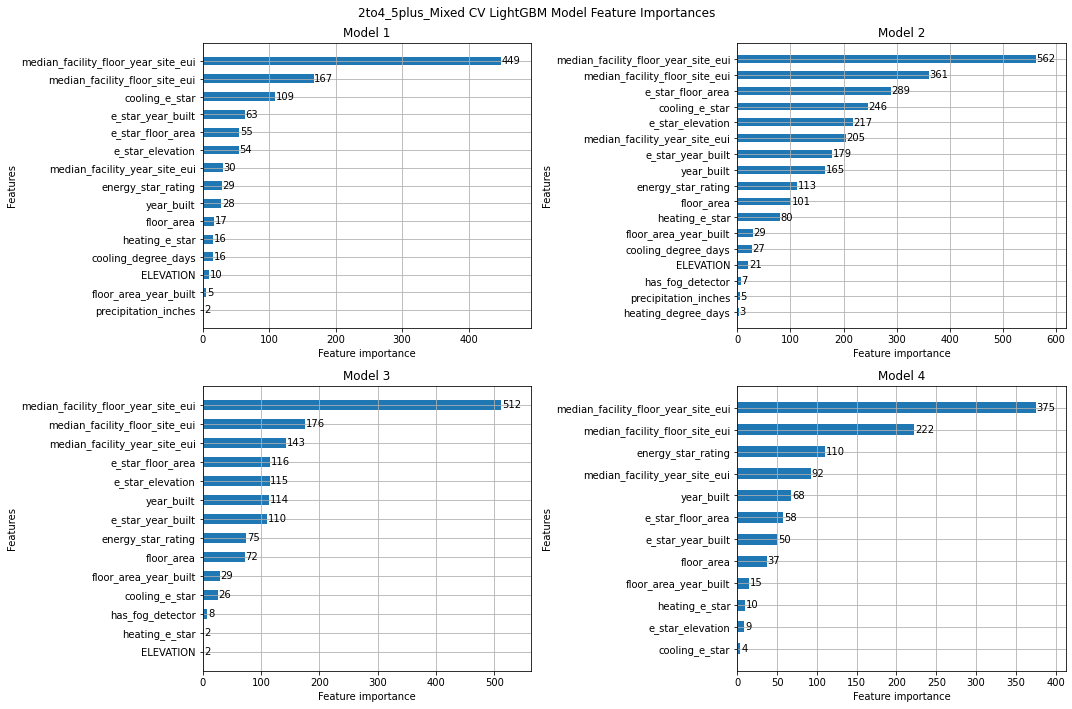

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for n, (i, ax) in enumerate(zip(range(len(models["2to4_5plus_Mixed"])), axes.ravel())):
    lgb.plot_importance(models["2to4_5plus_Mixed"][i], figsize=(5, 5), height=0.5, max_num_features=20, ax=ax);
    ax.set_title(f"Model {n+1}")

fig.suptitle("2to4_5plus_Mixed CV LightGBM Model Feature Importances")
plt.tight_layout()

# Section 6: Final models and predictions

This section contains my final ML models and their resulting predictions:

- The final model I used was an ensemble of XGB, lightGBM, and CatBoost regressors.
- You will need to use a GPU to run this section of the notebook, or, comment out the GPU code lines (although this will take a long time if you only use a CPU).
- If you re-run this notebook multiple times, the predictions are a bit unstable after the 4th decimal point, I'm not 100% sure why this is since the random seeds are set.

In [24]:
regressor = VotingRegressor([
    (
        "xgb", 
        xgb.XGBRegressor(
            n_estimators=1000,
            max_depth=8,
            learning_rate=0.15,
            verbosity=0,
            tree_method="gpu_hist",
            random_state=SEED,
        )
    ),
    (
        "lgb",
        lgb.LGBMRegressor(
            force_row_wise=True,
            max_depth=8,
            learning_rate=0.15,
            n_estimators=1000,
            num_leaves=256,
            device="gpu",
            random_state=SEED
        )
    ),
    (
        "cb",
        cb.CatBoostRegressor(
            n_estimators=1000,
            learning_rate=0.15,
            max_depth=8,
            verbose=False,
            random_seed=SEED,
            task_type="GPU"
        )
    )
])

In [25]:
predictions = train_and_predict(regressor, X_trains, y_trains, X_tests, ct, TARGET)
assert sum(predictions.isna().sum()) == 0

In [26]:
predictions

,id,site_eui
0,75757,155.549032
1,75758,258.086220
2,75759,150.143738
3,75760,264.746211
4,75761,248.320594
...,...,...
1651,85457,25.020310
1652,85458,20.937206
1653,85459,36.654323
1654,85460,28.338381


In [27]:
predictions.to_csv("submission.csv", index=False)

# Thank You!

Thank you for taking the time to review my 2022 WiDS Kaggle Notebook.  As always, any feedback or comments are welcomed.  Also, please feel free to reach out to me to just chat about data science or machine learning in general!